<a href="https://colab.research.google.com/github/orionhunts-ai/new_models_datasets/blob/main/morpheus_cyber_gpt4o_mini_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# @title Install Core Libraries { run: "auto", display-mode: "form" }
%pip -qqq install loguru
from loguru import logger
_logger = logger
RUN=0
if RUN == 0:
  try:
    !pip install -qqq -U torch==2.3.1 pyarrow
    #%pip -qqq install torch==2.2.2
    !pip -qqq install transformers datasets wandb
  except Exception as e:
    _logger.error(e,exc_info=True)

RUN += 1

# Fine Tuning OpenAI GPT-4o For (Free) Agentic Cyber 👾

  *  Training (and reporting) on Google Colab
   for access to their high powered CUDA and  
  Leveraging
    * fine tuning on dataset ```"swaption2009/cyber-threat-intelligence-custom-data”```
    * Open AI offering this mini version of the already efficient gpt4o.
        * OAI claims that the mini is almost as performant (but it's 20x cheaper)
    * Sampling from the full set for those that are most relevant to Cyber Security Analysts.***

    * Aside from traditional and evolving Evaluations I will also deploy a number of the finely tuned models in a Microsoft Autogen agentic environment to see how they perform on basic analysis on a database.

    * ```Red Panda``` (a high performance streaming data alternative to ```Kafka``` will be used)



## What about Phi!?!
The last experiment with Phi is still ongoing. I am having CUDA compatibility issues between the librares and it's a good chance to learn a bit deeper into that stack


##  Data and Tool Preparation
**Summary:**

This study explores the fine-tuning of the Phi-3-small-instruct model (7.39 billion parameters) by using Daniel So's Unsloth for a Cyber Threat Intelligence (CTI) task using methods like Parameter-Efficient Fine-Tuning (PEFT), Low-Rank Adaptation (LoRA), and Quantized Low-Rank Adaptation (QLoRA). It aims to evaluate performance degradation, model collaboration in agentic environments, and the potential influence of GPT-4. Synthetic data from gretel.ai was also utilized to supplement the fine-tuning process and enhance data diversity and robustness.

In [17]:
!python -m pip install -qqq huggingface_hub wandb
import wandb
from google.colab import userdata
wandb.login(key=userdata.get('WANDB_API_KEY'))

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [18]:
#ML Ops and EDA Imports
import os
import torch
import pandas as pd
import numpy as np

wandb.login(key=userdata.get('WANDB_API_KEY'))
wandb.init(project="Cyber-gpt4o-mini-HFData")
HF_TOKEN = userdata.get("HF_TOKEN")
!huggingface-cli login --token HF_TOKEN
device = "cuda:0" if torch.cuda.is_available() else "cpu"
_logger.info(device)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Traceback (most recent call last):
  File "/usr/local/bin/huggingface-cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/huggingface_cli.py", line 51, in main
    service.run()
  File "/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/user.py", line 98, in run
    login(token=self.args.token, add_to_git_credential=self.args.add_to_git_credential)
  File "/usr/local/lib/python3.10/dist-packages/huggingface_hub/_login.py", line 111, in login
    _login(token, add_to_git_credential=add_to_git_credential, write_permission=write_permission)
  File "/usr/local/lib/python3.10/dist-packages/huggingface_hub/_login.py", line 307, in _login
    raise ValueError("Invalid token passed!")
Value

2024-07-25 10:16:07.532 | INFO     | __main__:<cell line: 12>:12 - cuda:0


In [19]:
# Loading pre-determined Cyber Data - Create your own Synthetic data on top at https://gretel.ai/'''
import pandas as pd
try:
  from datasets import load_dataset
  ds = load_dataset("swaption2009/cyber-threat-intelligence-custom-data")
  _logger.debug(ds)
  df_train = ds['train'].to_pandas()
  _logger.debug(df_train[0:10])
  _logger.debug(type(df_train))
  _logger.debug(df_train.head())
  _logger.info({df_train[0]})

except Exception as e:
  _logger.error(f'{e}', exc_info=True)



2024-07-25 10:16:08.838 | DEBUG    | __main__:<cell line: 3>:6 - DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'entities', 'relations', 'diagnosis', 'solutions'],
        num_rows: 476
    })
})
2024-07-25 10:16:08.842 | DEBUG    | __main__:<cell line: 3>:8 -       id                                               text  \
0    249  A cybersquatting domain save-russia[.]today is...   
1  14309  Like the Android Maikspy, it first sends a not...   
2  13996  While analyzing the technical details of this ...   
3  13600  (Note that Flash has been declared end-of-life...   
4  14364  Figure 21. Connection of Maikspy variants to 1...   
5  13565  The source code of this framework is shared ac...   
6   2400  The CVE-2022-22965 vulnerability allows an att...   
7  14126  At the same time, we were able to locate the M...   
8   1929  But this link is further fortified by the Andr...   
9   1921   A malicious RTF file that exploits the CVE-20...   

                        

# Data Cleaning and NLP

In [20]:
df_train.shape

(476, 6)

In [21]:
df_train.dropna().drop_duplicates()
df_train.shape

(476, 6)

In [22]:
df_train.columns
df_train.head()

,id,text,entities,relations,diagnosis,solutions
0,249,A cybersquatting domain save-russia[.]today is...,"[{'end_offset': 16, 'id': 44656, 'label': 'att...","[{'from_id': 44658, 'id': 9, 'to_id': 44659, '...",The diagnosis is a cyber attack that involves ...,1. Implementing DNS filtering to block access ...
1,14309,"Like the Android Maikspy, it first sends a not...","[{'end_offset': 17, 'id': 48530, 'label': 'SOF...","[{'from_id': 48531, 'id': 445, 'to_id': 48532,...",The diagnosis is that the entity identified as...,1. Implementing a robust anti-malware software...
2,13996,While analyzing the technical details of this ...,"[{'end_offset': 194, 'id': 48781, 'label': 'th...","[{'from_id': 48781, 'id': 461, 'to_id': 48782,...",Diagnosis: APT37/Reaper/Group 123 is responsib...,1. Implementing advanced threat detection tech...
3,13600,(Note that Flash has been declared end-of-life...,"[{'end_offset': 79, 'id': 51687, 'label': 'TIM...","[{'from_id': 51688, 'id': 1133, 'to_id': 51689...",The diagnosis is a malware infection. The enti...,1. Implementing a robust antivirus software th...
4,14364,Figure 21. Connection of Maikspy variants to 1...,"[{'end_offset': 191, 'id': 51779, 'label': 'UR...","[{'from_id': 51780, 'id': 1161, 'to_id': 44372...",The diagnosis is that Maikspy malware variants...,1. Implementing a robust firewall system that ...


In [23]:
columns=["text", "diagnosis",  "solutions"]
df_domains = df_train[columns]
df_domains.head()


,text,diagnosis,solutions
0,A cybersquatting domain save-russia[.]today is...,The diagnosis is a cyber attack that involves ...,1. Implementing DNS filtering to block access ...
1,"Like the Android Maikspy, it first sends a not...",The diagnosis is that the entity identified as...,1. Implementing a robust anti-malware software...
2,While analyzing the technical details of this ...,Diagnosis: APT37/Reaper/Group 123 is responsib...,1. Implementing advanced threat detection tech...
3,(Note that Flash has been declared end-of-life...,The diagnosis is a malware infection. The enti...,1. Implementing a robust antivirus software th...
4,Figure 21. Connection of Maikspy variants to 1...,The diagnosis is that Maikspy malware variants...,1. Implementing a robust firewall system that ...


In [24]:
# nlp cleaning
%pip install gensim nltk
import nltk
import gensim

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import random

def preprocess_text(text):
  row_count=0
  # Stop words remove Tokenize the text
  stop_words = set(stopwords.words('english'))
  tokens = word_tokenize(text.lower())
  filtered_sentence = [w for w in tokens if not w.lower() in stop_words and w.isalnum()]
  filterered_sentence=" ".join(filtered_sentence)

  row_count += 1


  return filtered_sentence



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
df_domains.shape


(476, 3)

In [13]:
# Tokenise and remove stopwords + Concatenate Scenario and Outcome
%pip install tqdm
from tqdm import tqdm
import random
import sys
import time
from tqdm import tqdm_notebook
tqdm.pandas()
df_scenario_outcome = df_domains.copy()
try:
    # Apply preprocessing function with progress bar
    tqdm.pandas()
    df_scenario_outcome["scenario_outcome"] = df_scenario_outcome["scenario_outcome"].progress_apply(preprocess_text)
    # Concatenate scenario and outcome
    df_scenario_outcome["scenario_outcome"] = df_domains.progress_apply(
    lambda row: 'Scenario: ' + str(row["text"]) + ' Outcome: ' + str(row["diagnosis"]), axis=1)

except Exception as e:
    print(f'Error: {e}', file=sys.stderr)
    sys.exit(1)





100%|██████████| 476/476 [00:00<00:00, 1464.71it/s]

                                                  text  \
0    A cybersquatting domain save-russia[.]today is...   
1    Like the Android Maikspy, it first sends a not...   
2    While analyzing the technical details of this ...   
3    (Note that Flash has been declared end-of-life...   
4    Figure 21. Connection of Maikspy variants to 1...   
..                                                 ...   
471  Cyclops Blink, an advanced modular botnet that...   
472   Sofacy Group has been associated with many at...   
473  The plugin has been designed to drop multiple ...   
474  We have uncovered a cyberespionage campaign be...   
475  Based on the analysis of samples that were las...   

                                             diagnosis  \
0    The diagnosis is a cyber attack that involves ...   
1    The diagnosis is that the entity identified as...   
2    Diagnosis: APT37/Reaper/Group 123 is responsib...   
3    The diagnosis is a malware infection. The enti...   
4    The diag

In [15]:
print(df_scenario_outcome['scenario_outcome'])
df_scenario_outcome.shape
df_scenario_outcome.columns

0      [scenario, cybersquatting, domain, today, laun...
1      [scenario, like, android, maikspy, first, send...
2      [scenario, analyzing, technical, details, malw...
3      [scenario, note, flash, declared, adobe, since...
4      [scenario, figure, connection, maikspy, varian...
                             ...                        
471    [scenario, cyclops, blink, advanced, modular, ...
472    [scenario, sofacy, group, associated, many, at...
473    [scenario, plugin, designed, drop, multiple, p...
474    [scenario, uncovered, cyberespionage, campaign...
475    [scenario, based, analysis, samples, last, see...
Name: scenario_outcome, Length: 476, dtype: object


Index(['text', 'diagnosis', 'solutions', 'scenario_outcome'], dtype='object')

In [ ]:
if df_domains["text_diagnosis"]:
  try:
    df_domains['solutions_processed'] = tqdm(df_domains['solutions'][ran_num:ran_num2].apply(preprocess_text))
  except Exception as e:
    _logger.error(f'{e}', exc_info=True)
    sys.exit(1)


  df_domains['text_processed'] = tqdm(df_domains['text'].apply(preprocess_text))
  df_domains['diagnosis_processed'] = tqdm(df_domains['diagnosis'][ran_num:ran_num2].apply(preprocess_text))
  df_tokenized=df_domains.copy().drop(['text','diagnosis', 'solutions'])
  df_tokenized.head()
except Exception as e:
  _logger.error(f'{e}', exc_info=True)


In [ ]:
# Sentiment Analysis Column
%pip install transformers
%pip install torch accelerate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
# Load the tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# Set up the classifier
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Function to predict sentiment
def predict_sentiment(text):
    result = classifier(text)
    label = result[0]['label']
    return label
## Apply to copied DF
df_sentiment = df_tokenized.copy()
df_sentiment['sentiment'] = df_sentiment['solutions_processed'].apply(predict_sentiment)
df_sentiment.head()

NameError: name 'df_tokenized' is not defined

In [ ]:
### Text-Diagnosis Concatenation & HotEncoder Target
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
# FIX THIS
df_encoded = df_tokenized.copy()
df_encoded['text_diagnosis'] = df_text_diagnosis['text_processed'] + df_text_diagnosis['diagnosis_processed']

df_encoded.head()

In [ ]:
# Train a Word2Vec model (example)
apply_word2Vec[column for column in columns]
model = Word2Vec(df_domains['text_processed'], min_count=1)

In [ ]:
# Apply the function to each column
df_w2v = df_domains.copy()
df_w2v['text_processed'] = df_domains['text'].apply(preprocess_text)
df_w2v['diagnosis_processed'] = df_domains['diagnosis'].apply(preprocess_text)
df_w2v['solutions_processed'] = df_domains['solutions'].apply(preprocess_text)

In [ ]:
# Use OAI Embeddings
%pip install -qqq openai
import openai
openai.api_key = userdata.get("OPENAI_API_KEY")
oai_model="text-embedding-3-small"

def get_openai_embedding(text,engine=oai_model):
    response = openai.Embedding.create(
      input=text,
      engine=engine  # Or another model you prefer
    )
    return response['text'][0]['embedding']


In [ ]:
# prompt: Using dataframe df: make a dataframe called df_domain with only rows in the df_domains list and perform other data cleaning on the df_domain dataframe

# Assuming df_domains is a list of domains to filter by
df_domains = ['artificial intelligence','defense industry', 'defense operations', 'defense security', 'cybersecurity',
              'defence contractors', 'technology']
df_domain = df[df['domain'].isin(df_domains)].copy()


df_domain = df_domain.drop_duplicates()
df_domain = df_domain.dropna()


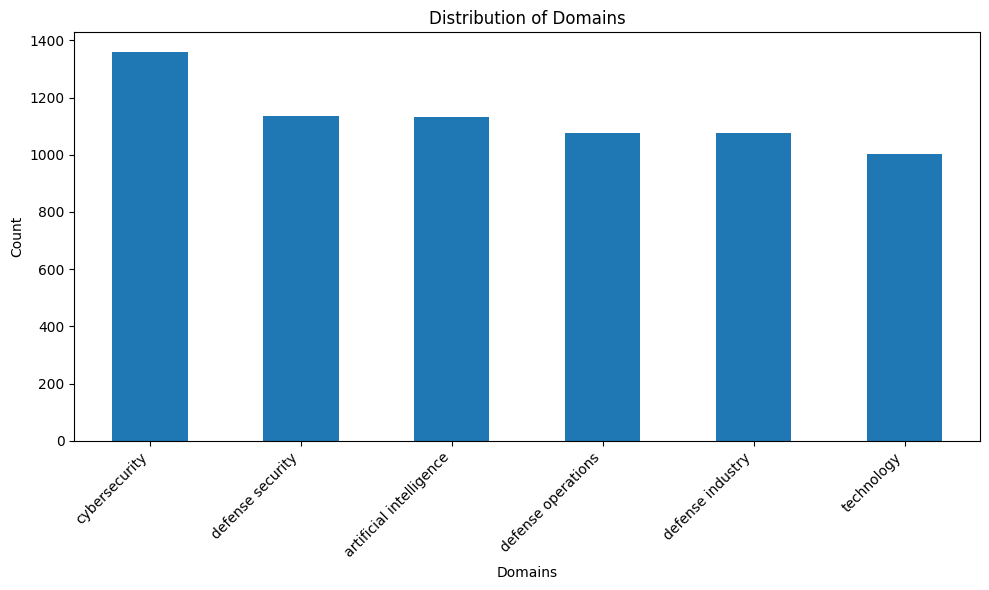

In [ ]:
# prompt: a vertical bar chart showing the distribution of domains in the dataframe

import matplotlib.pyplot as plt

# Assuming 'domain' is a column in your dataframe
domain_counts = df_domain['domain'].value_counts()

plt.figure(figsize=(10, 6))
domain_counts.plot(kind='bar')
plt.xlabel('Domains')
plt.ylabel('Count')
plt.title('Distribution of Domains')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


*** Data set is relatively balanced therefore there is no need for any manipulation or rebalancing of the domains. Fortunately, cybersecurity is the most well represented - Dataset Ready to go ***

# Preparing to Train
1. Isolate important columns.
2. Choose our target (SQL!)\
3. Split into 80/20 (train/test)


# Fine Tuning Using Different Approaches
1. Open AI gpt-4o mini with small embeddings from OAI
2. Open AI gpt-4o mini with Word2Vec

1. Word2Vec model with Sentence Transformers

** After we have the models we will train them

In [ ]:
# prompt: train test split from sklearn 0.1 size , random_stat42

from sklearn.model_selection import train_test_split
train, test = train_test_split(df_train, test_size=0.1, random_state=42)


In [ ]:
### Need to concat the features.
#System Messages : 1 Assistant
{"messages": [{"role": "system", "content": "For each scenario there is a Situation: Diagnosis, and Solutions. Decide if they are good solutions."}, {"role": "user", "content": {random.randint(0,len(feature_concat))}}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
{"messages": [{"role": "system", "content": "For each scenario there is a Diagnosis and Solutions. Decide if they are good"}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
{"messages": [{"role": "system", "content": "For each scenario there is a Diagnosis and Solutions. Decide if they are good"}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}


In [ ]:
#System Messages : Multiple Assistants
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris", "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already.", "weight": 1}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "William Shakespeare", "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?", "weight": 1}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "384,400 kilometers", "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters.", "weight": 1}]}

In [ ]:
import json

#Define Template
system_messages = [{sys}]
prefix = {'messages':{"role:"system", "content": "Here are a variety of solutions to cyber problems. Analyze and give a binary 0 for no and 1 for yes.'}}}
postfix =

with open("./text_sql.json", "w") as f:
    json.dump(template, f)

In [ ]:
# DF to JSON Serialized
df_to_json = df_domain.to_json('./text_sql.json', orient='records')

In [ ]:
run = wandb.init(project="Cyber-Phi-Small-8k-instruct", job_type="dataset")
artifact = wandb.Artifact(name="df_to_json", type="dataset")
run.log_artifact(artifact)

run.finish()

ValueError: Artifact df_to_json already exists with type 'data'; cannot create another with type 'dataset'



---



## Model Training
1. Tokenize with TikToken
2. @ 4bit for improved speed traded off for lower precision calculation on weights.

In [ ]:
run2 = wandb.init(project="Cyber-Phi-Small-8k-instruct", job_type="train")
run3 = wandb.init(project="gpt4o-mini", job_type="train")

In [ ]:
# Load model directly from HuggingFace
%pip install -qq tiktoken einops
%pip install  -q torch==2.2.2+cu121 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 torchtext==0.15.2 torchdata==0.6.1 --extra-index-url https://download.pytorch.org/whl/cu121 -U
_logger.info(device)
from unsloth import FastLanguageModel
import torch
import tiktoken
import einops
from transformers import AutoModelForCausalLM

max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3-small-8k-instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    #token = os.getenv("WANDB_API_KEY"), # use one if using gated models like meta-llama/Llama-2-7b-hf
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 1.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torchvision==0.15.2+cu118 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.0+cu121, 0.16.1, 0.16.1+cu121, 0.16.2, 0.16.2+cu121, 0.17.0, 0.17.0+cu121, 0.17.1, 0.17.1+cu121, 0.17.2, 0.17.2+cu121, 0.18.0, 0.18.0+cu121, 0.18.1, 0.18.1+cu121)
ERROR: No matching distribution found for torchvision==0.15.2+cu118
cuda:0


RuntimeError: Unsloth: `unsloth/Phi-3-small-8k-instruct` is not a base model or a PEFT model.
We could not locate a `config.json` or `adapter_config.json` file.
Are you certain the model name is correct? Does it actually exist?

### Extract Entities for Graph
1. Make new dataFrame wth text an relations broken down, then labelled with Node or Relationship.


In [ ]:
import numpy as np
df_Graph = df_train.copy()
def graph_df(text):
  columns = text.unique()
  graph_df=pd.DataFrame(columns=columns)
  return graph_df
print(df_Graph.head())
graph_df = graph_df(df_Graph['entities'])
graph_df.shape
new_df = pd.DataFrame(columns=graph_df[0::])
new_df.head()
for k, v in enumerate(new_df.index):
  print(f'k is {k} and v is {v}')
  print(v)
  #new_df[f"{v}"] = df_Graph['entities'][k].split(',')
  #print(new_df[f"{v}]"])
  #print(graph_df.head())

#print(graph_df.describe)
#print(graph_df.head())
#print(np.array_split(values=graph_df,)

      id                                               text  \
0    249  A cybersquatting domain save-russia[.]today is...   
1  14309  Like the Android Maikspy, it first sends a not...   
2  13996  While analyzing the technical details of this ...   
3  13600  (Note that Flash has been declared end-of-life...   
4  14364  Figure 21. Connection of Maikspy variants to 1...   

                                            entities  \
0  [{'end_offset': 16, 'id': 44656, 'label': 'att...   
1  [{'end_offset': 17, 'id': 48530, 'label': 'SOF...   
2  [{'end_offset': 194, 'id': 48781, 'label': 'th...   
3  [{'end_offset': 79, 'id': 51687, 'label': 'TIM...   
4  [{'end_offset': 191, 'id': 51779, 'label': 'UR...   

                                           relations  \
0  [{'from_id': 44658, 'id': 9, 'to_id': 44659, '...   
1  [{'from_id': 48531, 'id': 445, 'to_id': 48532,...   
2  [{'from_id': 48781, 'id': 461, 'to_id': 48782,...   
3  [{'from_id': 51688, 'id': 1133, 'to_id': 51689...   
4  [

In [ ]:
def load_and_log():

    # 🚀 start a run, with a type to label it and a project it can call home
    with wandb.init(project="artifacts-data-models", job_type="load-data") as run:

        datasets = load()  # separate code for loading the datasets
        names = ["training", "validation", "test"]

        # 🏺 create our Artifact
        raw_data = wandb.Artifact(
            "cyber-phi", type="dataset",
            description="Cyber-Phi",
            metadata={"source": "torchvision.datasets.MNIST",
                      "sizes": [len(dataset) for dataset in datasets]})

        for name, data in zip(names, datasets):
            # 🐣 Store a new file in the artifact, and write something into its contents.
            with raw_data.new_file(name + ".pt", mode="wb") as file:
                x, y = data.tensors
                torch.save((x, y), file)

        # ✍️ Save the artifact to W&B.
        run.log_artifact(raw_data)

load_and_log()



---
###APPENDIX A

### 🤗Fine-Tuning Techniques: 🤗

**PEFT** (Parameter-Efficient Fine-Tuning): Fine-tunes pre-trained models by adjusting only a small subset of parameters, reducing computational costs.

**LoRA** (Low-Rank Adaptation): Enhances transformer models by injecting and training low-rank matrices within each layer, minimizing the number of trainable parameters.

**QLoRA** (Quantized Low-Rank Adaptation): Combines low-rank adaptation with weight quantization to achieve efficient fine-tuning with reduced memory and computational requirements.

**Full Fine-Tuning:** Updates all parameters of the pre-trained model, offering high flexibility at the cost of increased computational resources.

**Distillation:** Trains a smaller model to mimic the behavior of a larger pre-trained model, optimizing efficiency while maintaining performance.